In [ ]:
import matplotlib.pyplot as plt 
from CoolProp.CoolProp import PropsSI
import CoolProp.CoolProp as CP

import numpy as np
import pandas as pd


In [49]:
# atmospheric pressure
P_atm = 101325 / 1e5 # bar

RKB = 23.5
Z_sf = -312 #seafloor depth [m]


# reservoir aquifer pressure
aq_P = 60 # bar
aq_P = 124

# reservoir reference depth
aq_Z = -1217 # mTVDMSL

# injection pointo r base of CO2 column
base_CO2_Z = -1312 # m

# base of cement plug/barrier
barrier_Z = -562

#density brine
rho_brine = 1024 # kg/m3

#gravity acceleration
G_acc = 9.8067 # m/s2

#Create depth vector
top = 0
base = 1500

z = -np.linspace(top, base, 1+(base-top))
df = pd.DataFrame(data={'depth':z})

fluid1 = 'CO2'
fluid2 = 'HEOS::CO2[0.96]&H2[0.004]&Ar[0.01]&N2[0.0084]&CH4[0.0178]'
fluid = 'CO2'

def P_aquifer(z, ref_Z, ref_P, rho = 1024, g = 9.8067):
    """
    Creates a hydrostatic gradient based on a given density that matches a reference pressure, depth point
    """

    P_offset = ref_P*1e5 + ref_Z*rho*g
    P = (-(z*g*rho) + P_offset) / 1e5
    return P

#Hydrostatic gradient



df['P_aq'] = P_aquifer(z=z, ref_P=aq_P, ref_Z=aq_Z)
df['P_hyd'] = P_atm-(df['depth']*rho_brine*G_acc)/1e5

df['Sh_min'] = df['P_hyd']
df.loc[df.depth<Z_sf, 'Sh_min'] = -(Z_sf*rho_brine*G_acc)/1e5 - 0.166*(df.loc[df.depth<Z_sf, 'depth']-Z_sf)

df


df.loc[df.depth>barrier_Z, 'P_aq'] =  df.loc[df.depth>barrier_Z, 'P_hyd']
df.loc[df.P_aq < P_atm, 'P_aq'] = 0

#Temperature
Tgrad = 40/1000 #thermal gradient [m/degC]
T_sf = 4 #seafloor temperature [degC]

df['Temp'] = T_sf - (df['depth']-Z_sf)*Tgrad #geothermal temperature field






# hydrostatic pressure at CO2 base
base_CO2_Phyd = P_aquifer(z=base_CO2_Z, ref_P=aq_P, ref_Z=aq_Z)

# hydrostatic pressure at barrier base
barrier_Phyd = P_aquifer(z=barrier_Z, ref_P=aq_P, ref_Z=aq_Z)

#vertical height between base of CO2 and base of barrier
col_CO2_height = barrier_Z - base_CO2_Z

# CO2 column
df['CO2_h'] = df['depth'] - base_CO2_Z
df.loc[(df['CO2_h']<0) | (df['CO2_h']>col_CO2_height), 'CO2_h'] = 0

# delta z
df['dz'] = df.depth.diff()

# create a column for P
df['P'] = df['P_aq']
df['P1'] = df['P_aq']
df['P2'] = df['P_aq']

# create a column for Pcap
df['dPcap'] = 0
df['Pcap'] = 0

df['dPcap1'] = 0
df['Pcap1'] = 0

df['dPcap2'] = 0
df['Pcap2'] = 0

df['rho_g'] = 0
df['rho_g1'] = 0
df['rho_g2'] = 0
df['phase'] = ''
df['phase1'] = ''
df['phase2'] = ''





query = df.query('depth>=@base_CO2_Z & depth<=@barrier_Z')


for idx, row in query.iloc[::-1].iterrows():

    col_h  = row.CO2_h
    z_val = row.depth
    dz = row.dz
    T = row.Temp
    P_aq = row.P_aq

    if col_h == 0:
        P = P_aq
        P1 = P_aq
        P2 = P_aq
        rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, fluid)
        rho_g1 = PropsSI("D", "P", P*1e5, "T", T+273.15, fluid1)
        rho_g2 = PropsSI("D", "P", P*1e5, "T", T+273.15, fluid2)

        df.loc[idx, 'rho_g'] = rho_g
        df.loc[idx, 'rho_g1'] = rho_g1
        df.loc[idx, 'rho_g2'] = rho_g2
        Pcap = 0
        Pcap1 = 0
        Pcap2 = 0

        P_previous = P
        P_previous1 = P1
        P_previous2 = P2
        
    else:
        dPcap = -((rho_brine - rho_g)*dz*G_acc)/1e5
        dPcap1 = -((rho_brine - rho_g1)*dz*G_acc)/1e5
        dPcap2 = -((rho_brine - rho_g2)*dz*G_acc)/1e5


        Pcap += dPcap
        Pcap1 += dPcap1
        Pcap2 += dPcap2

        df.loc[idx, 'dPcap'] = dPcap
        df.loc[idx, 'Pcap'] = Pcap
        df.loc[idx, 'dPcap1'] = dPcap1
        df.loc[idx, 'Pcap1'] = Pcap1
        df.loc[idx, 'dPcap2'] = dPcap2
        df.loc[idx, 'Pcap2'] = Pcap2

        P = P_aq + Pcap
        P1 = P_aq + Pcap1
        P2 = P_aq + Pcap2


        df.loc[idx, 'P'] = P
        df.loc[idx, 'P1'] = P1
        df.loc[idx, 'P2'] = P2
        
        
        
        rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, fluid)
        rho_g1 = PropsSI("D", "P", P1*1e5, "T", T+273.15, fluid1)
        rho_g2 = PropsSI("D", "P", P2*1e5, "T", T+273.15, fluid2)

        # try:
        #     rho_g = PropsSI("D", "P", P*1e5, "T|gas", T+273.15, fluid)
        # except:
        #     rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, fluid)


        phase = CP.PhaseSI("P", P*1e5, "T", T+273.15, fluid)
        phase1 = CP.PhaseSI("P", P1*1e5, "T", T+273.15, fluid1)
        phase2 = CP.PhaseSI("P", P2*1e5, "T", T+273.15, fluid2)

        

        df.loc[idx, 'rho_g'] = rho_g
        df.loc[idx, 'rho_g1'] = rho_g1
        df.loc[idx, 'rho_g2'] = rho_g2

        df.loc[idx, 'phase'] = phase
        df.loc[idx, 'phase1'] = phase1
        df.loc[idx, 'phase2'] = phase2

        rho_previous = rho_g
        rho_previous1 = rho_g1
        rho_previous2 = rho_g2
        
            



In [ ]:
query = df.query('depth>=@base_CO2_Z & depth<=@barrier_Z')
query.iloc[0]


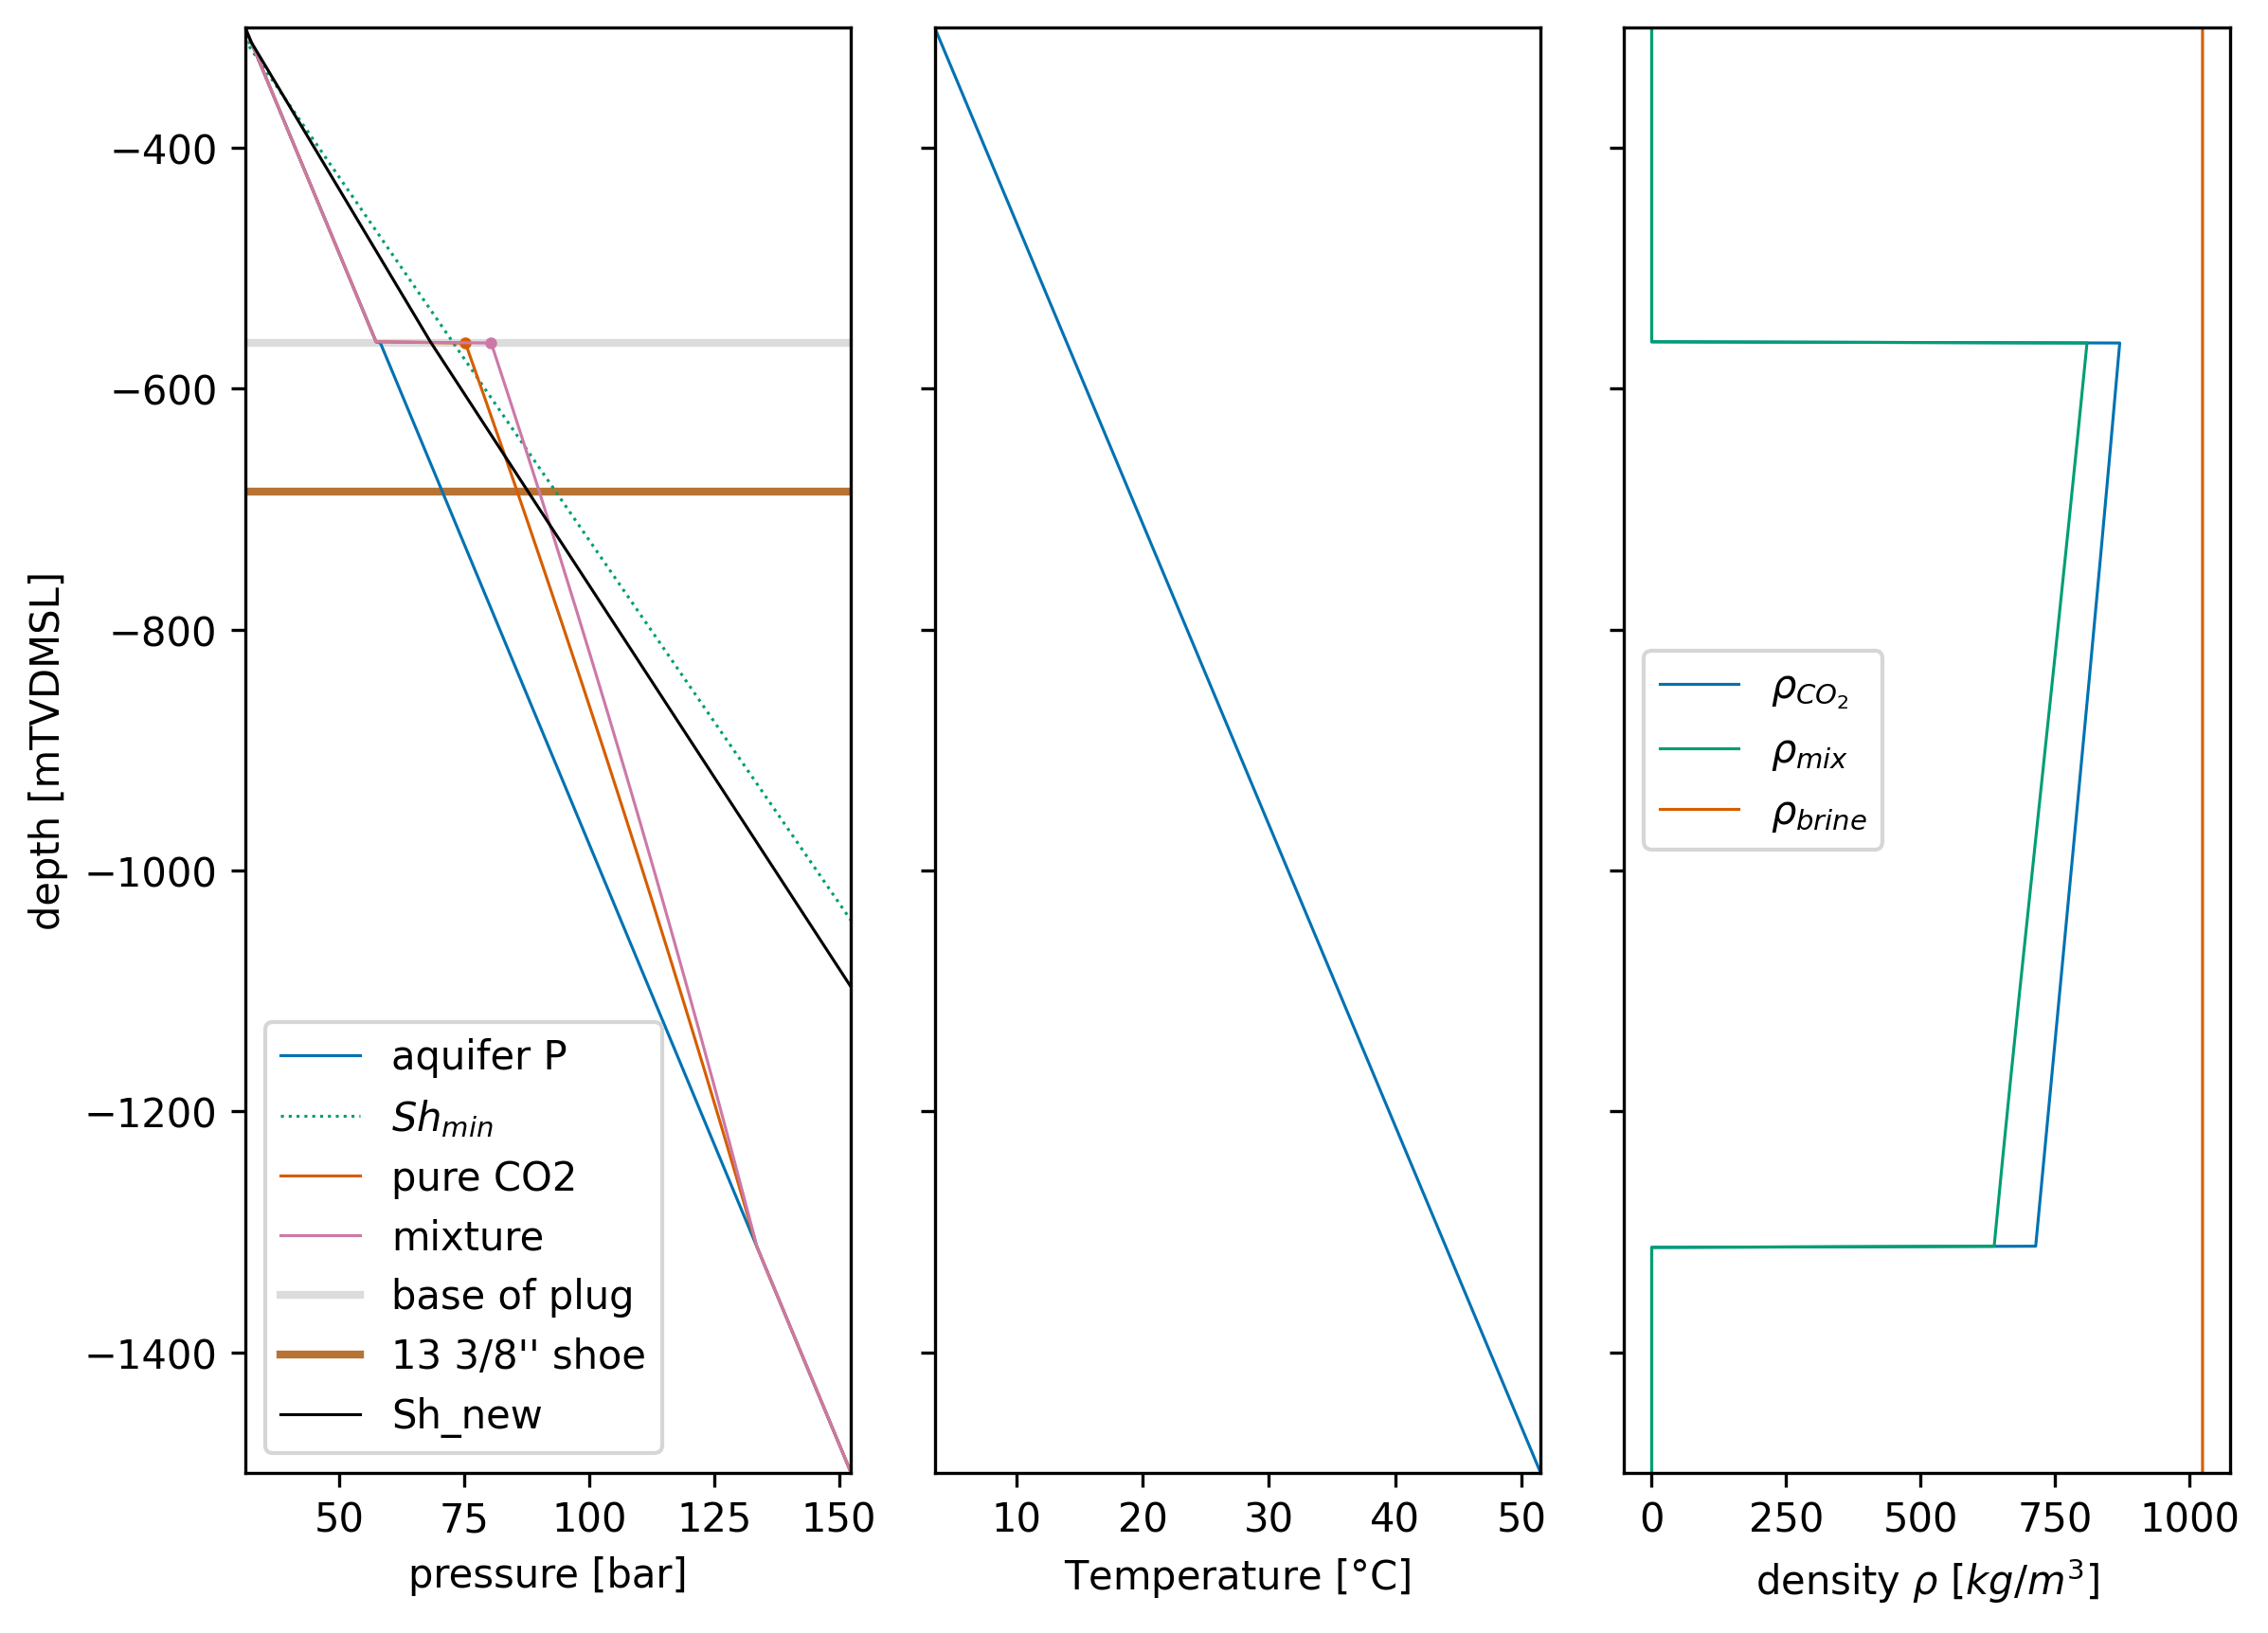

In [57]:
import matplotlib as mpl

style = plt.style.available[13]
plt.style.use(style)

mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.figsize'] = [8.1, 5.85]
mpl.rcParams['lines.linewidth'] = 0.75
mpl.rcParams['lines.markersize'] = 2

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True)

df.plot(x='P_aq', y='depth', ax= ax1, label='aquifer P')
# df.plot(x='P_hyd', y='depth', ax= ax1, label='hydrostatic P', linestyle=':')
df.plot(x='Sh_min', y='depth', ax= ax1, label='$Sh_{min}$', linestyle=':')


# df.plot(x='P', y='depth', ax= ax1, label=fluid)

query = df.query('depth>=@base_CO2_Z & depth<=@barrier_Z')


df.plot(x='P1', y='depth', ax= ax1, label='pure CO2')
color = ax1.get_lines()[-1].get_color()
ax1.scatter(query.iloc[0]['P1'], query.iloc[0]['depth'], color= color)


df.plot(x='P2', y='depth', ax= ax1, label='mixture')
color = ax1.get_lines()[-1].get_color()
ax1.scatter(query.iloc[0]['P2'], query.iloc[0]['depth'], color= color)

# ax1.plot(PFT['pressure'], -PFT['depth'], ls=':')

df.plot(x='Temp', y='depth', ax= ax2, legend=False)
# df.plot(x='rho_g', y='depth', ax= ax3, label=r'$\rho_{CO_2}$')



df.plot(x='rho_g1', y='depth', ax= ax3, label=r'$\rho_{CO_2}$')
df.plot(x='rho_g2', y='depth', ax= ax3, label=r'$\rho_{mix}$')
df['rho_brine'] = rho_brine
df.plot(x='rho_brine', y='depth', ax= ax3, label=r'$\rho_{brine}$')




# ax3.plot(rho_g_0, df.depth, '--')
# ax3.plot(rho_g_f, df.depth, '--')
# ax3.plot(PFT['rhog'], -PFT['depth'])
ax1.axhline(barrier_Z, label='base of plug', color='gainsboro', lw = 2, zorder=0)
ax1.axhline(RKB-709, label="13 3/8'' shoe", color='#B87333', lw = 2, zorder=0)

# ax4.plot(PFT['sgas'], -PFT['depth'])
# sh_min = np.array([[366, 583, 723], [34, 68, 90]])

sh_min = np.array([[RKB, -Z_sf+RKB, 583, 723], [P_atm, P_atm-(Z_sf*rho_brine*G_acc)/1e5, 68, 90]])

from scipy import interpolate
x = RKB-sh_min[0]
y = sh_min[1]
sh_func = interpolate.interp1d(x, y, fill_value='extrapolate')
sh = sh_func(df.depth)

# ax1.plot(sh_min[1], RKB-sh_min[0], marker='o', color='k', ms=10, label='Sh_new')
ax1.plot(sh, df.depth, color='k', label='Sh_new')


ax1.legend(loc='lower left')
ax1.set_ylim(bottom = z.min(), top=-300)
ax1.set_xlim(left = df.loc[300, 'P_aq'], right=df.loc[int(-z.min()), 'P_aq'])
ax2.set_xlim(left = df.loc[300, 'Temp'], right=df.loc[int(-z.min()), 'Temp'])


ax1.set_xlabel('pressure [bar]')
ax2.set_xlabel('Temperature [$\degree$C]')
ax3.set_xlabel(r'density $\rho$ [$kg/m^3$]')
ax1.set_ylabel('depth [mTVDMSL]')
fig.tight_layout()
fig.savefig('Pressure_plot')

In [52]:
df.depth

,depth,P_aq,P_hyd,Sh_min,Temp,CO2_h,dz,P,P1,P2,...,Pcap1,dPcap2,Pcap2,rho_g,rho_g1,rho_g2,phase,phase1,phase2,rho_brine
0,-0.0,1.013250,1.013250,1.013250,-8.48,0.0,NaN,1.013250,1.013250,1.013250,...,0.0,0.0,0.0,0.0,0.0,0.0,,,,1024
1,-1.0,1.113671,1.113671,1.113671,-8.44,0.0,-1.0,1.113671,1.113671,1.113671,...,0.0,0.0,0.0,0.0,0.0,0.0,,,,1024
2,-2.0,1.214091,1.214091,1.214091,-8.40,0.0,-1.0,1.214091,1.214091,1.214091,...,0.0,0.0,0.0,0.0,0.0,0.0,,,,1024
3,-3.0,1.314512,1.314512,1.314512,-8.36,0.0,-1.0,1.314512,1.314512,1.314512,...,0.0,0.0,0.0,0.0,0.0,0.0,,,,1024
4,-4.0,1.414932,1.414932,1.414932,-8.32,0.0,-1.0,1.414932,1.414932,1.414932,...,0.0,0.0,0.0,0.0,0.0,0.0,,,,1024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,-1496.0,152.017350,151.242480,227.875230,51.36,0.0,-1.0,152.017350,152.017350,152.017350,...,0.0,0.0,0.0,0.0,0.0,0.0,,,,1024
1497,-1497.0,152.117770,151.342900,228.041230,51.40,0.0,-1.0,152.117770,152.117770,152.117770,...,0.0,0.0,0.0,0.0,0.0,0.0,,,,1024
1498,-1498.0,152.218191,151.443321,228.207230,51.44,0.0,-1.0,152.218191,152.218191,152.218191,...,0.0,0.0,0.0,0.0,0.0,0.0,,,,1024
1499,-1499.0,152.318611,151.543741,228.373230,51.48,0.0,-1.0,152.318611,152.318611,152.318611,...,0.0,0.0,0.0,0.0,0.0,0.0,,,,1024


In [42]:
23.5-sh_min[0]

array([-342.5, -559.5, -699.5])

In [45]:
df.loc[342:]

,depth,P_aq,P_hyd,Sh_min,Temp,CO2_h,dz,P,P1,P2,...,Pcap1,dPcap2,Pcap2,rho_g,rho_g1,rho_g2,phase,phase1,phase2,rho_brine
342,-342.0,35.357098,35.357098,36.31123,5.20,0.0,-1.0,35.357098,35.357098,35.357098,...,0.0,0.0,0.0,0.0,0.0,0.0,,,,1024
343,-343.0,35.457519,35.457519,36.47723,5.24,0.0,-1.0,35.457519,35.457519,35.457519,...,0.0,0.0,0.0,0.0,0.0,0.0,,,,1024
344,-344.0,35.557939,35.557939,36.64323,5.28,0.0,-1.0,35.557939,35.557939,35.557939,...,0.0,0.0,0.0,0.0,0.0,0.0,,,,1024
345,-345.0,35.658360,35.658360,36.80923,5.32,0.0,-1.0,35.658360,35.658360,35.658360,...,0.0,0.0,0.0,0.0,0.0,0.0,,,,1024
346,-346.0,35.758780,35.758780,36.97523,5.36,0.0,-1.0,35.758780,35.758780,35.758780,...,0.0,0.0,0.0,0.0,0.0,0.0,,,,1024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,-1496.0,152.017350,151.242480,227.87523,51.36,0.0,-1.0,152.017350,152.017350,152.017350,...,0.0,0.0,0.0,0.0,0.0,0.0,,,,1024
1497,-1497.0,152.117770,151.342900,228.04123,51.40,0.0,-1.0,152.117770,152.117770,152.117770,...,0.0,0.0,0.0,0.0,0.0,0.0,,,,1024
1498,-1498.0,152.218191,151.443321,228.20723,51.44,0.0,-1.0,152.218191,152.218191,152.218191,...,0.0,0.0,0.0,0.0,0.0,0.0,,,,1024
1499,-1499.0,152.318611,151.543741,228.37323,51.48,0.0,-1.0,152.318611,152.318611,152.318611,...,0.0,0.0,0.0,0.0,0.0,0.0,,,,1024


In [43]:
sh_min[1]

array([34, 68, 90])

In [ ]:
df.loc[342:]

In [ ]:
-sh_min[0]

In [ ]:
sh_min[1]

In [ ]:
sh_min = np.array([[366, 583, 723], [34, 68, 90]])
sh_min

In [ ]:
query = df.query('depth>=@base_CO2_Z & depth<=@barrier_Z')
query

In [ ]:
nx, ny = (101, 101)
T = np.linspace(-50, 70, nx)

P = np.linspace(1, 200, ny)
Tv, Pv = np.meshgrid(T, P)



Tv = Tv.flatten()
Pv = Pv.flatten()

density_coolprop = PropsSI("D", "P", Pv*1e5, "T", Tv+273.15, "CO2")



Pcrit = PropsSI('CO2', 'pcrit')
Tcrit = PropsSI('CO2', 'Tcrit')

Tphase = np.linspace(273.15-50, Tcrit, 2000)
Pphase = PropsSI('P','T',Tphase,'Q',0,'CO2')

Tv = Tv.reshape(nx, ny)
Pv = Pv.reshape(nx, ny)
density_coolprop = density_coolprop.reshape(nx, ny)

fig, ax = plt.subplots()

pcm = ax.pcolormesh(Tv, Pv, density_coolprop, shading='nearest')

ax.scatter(Tcrit-273.15, Pcrit/1e5, c='red', label='critical P,T')
ax.plot(Tphase-273.15, Pphase/1e5, c='red', ls=':')
ax.set_xlabel('T [$\degree$C]')
ax.set_ylabel('P [bar]')

df.plot(x='Temp', y='P_hyd', ax=ax)
df.plot(x='Temp', y='P', ax=ax)

fig.colorbar(pcm, label = r'$\rho_{CO_2}$ [$kg/m^3$]')

fig.tight_layout()

# fig.savefig('CO2_density.png')


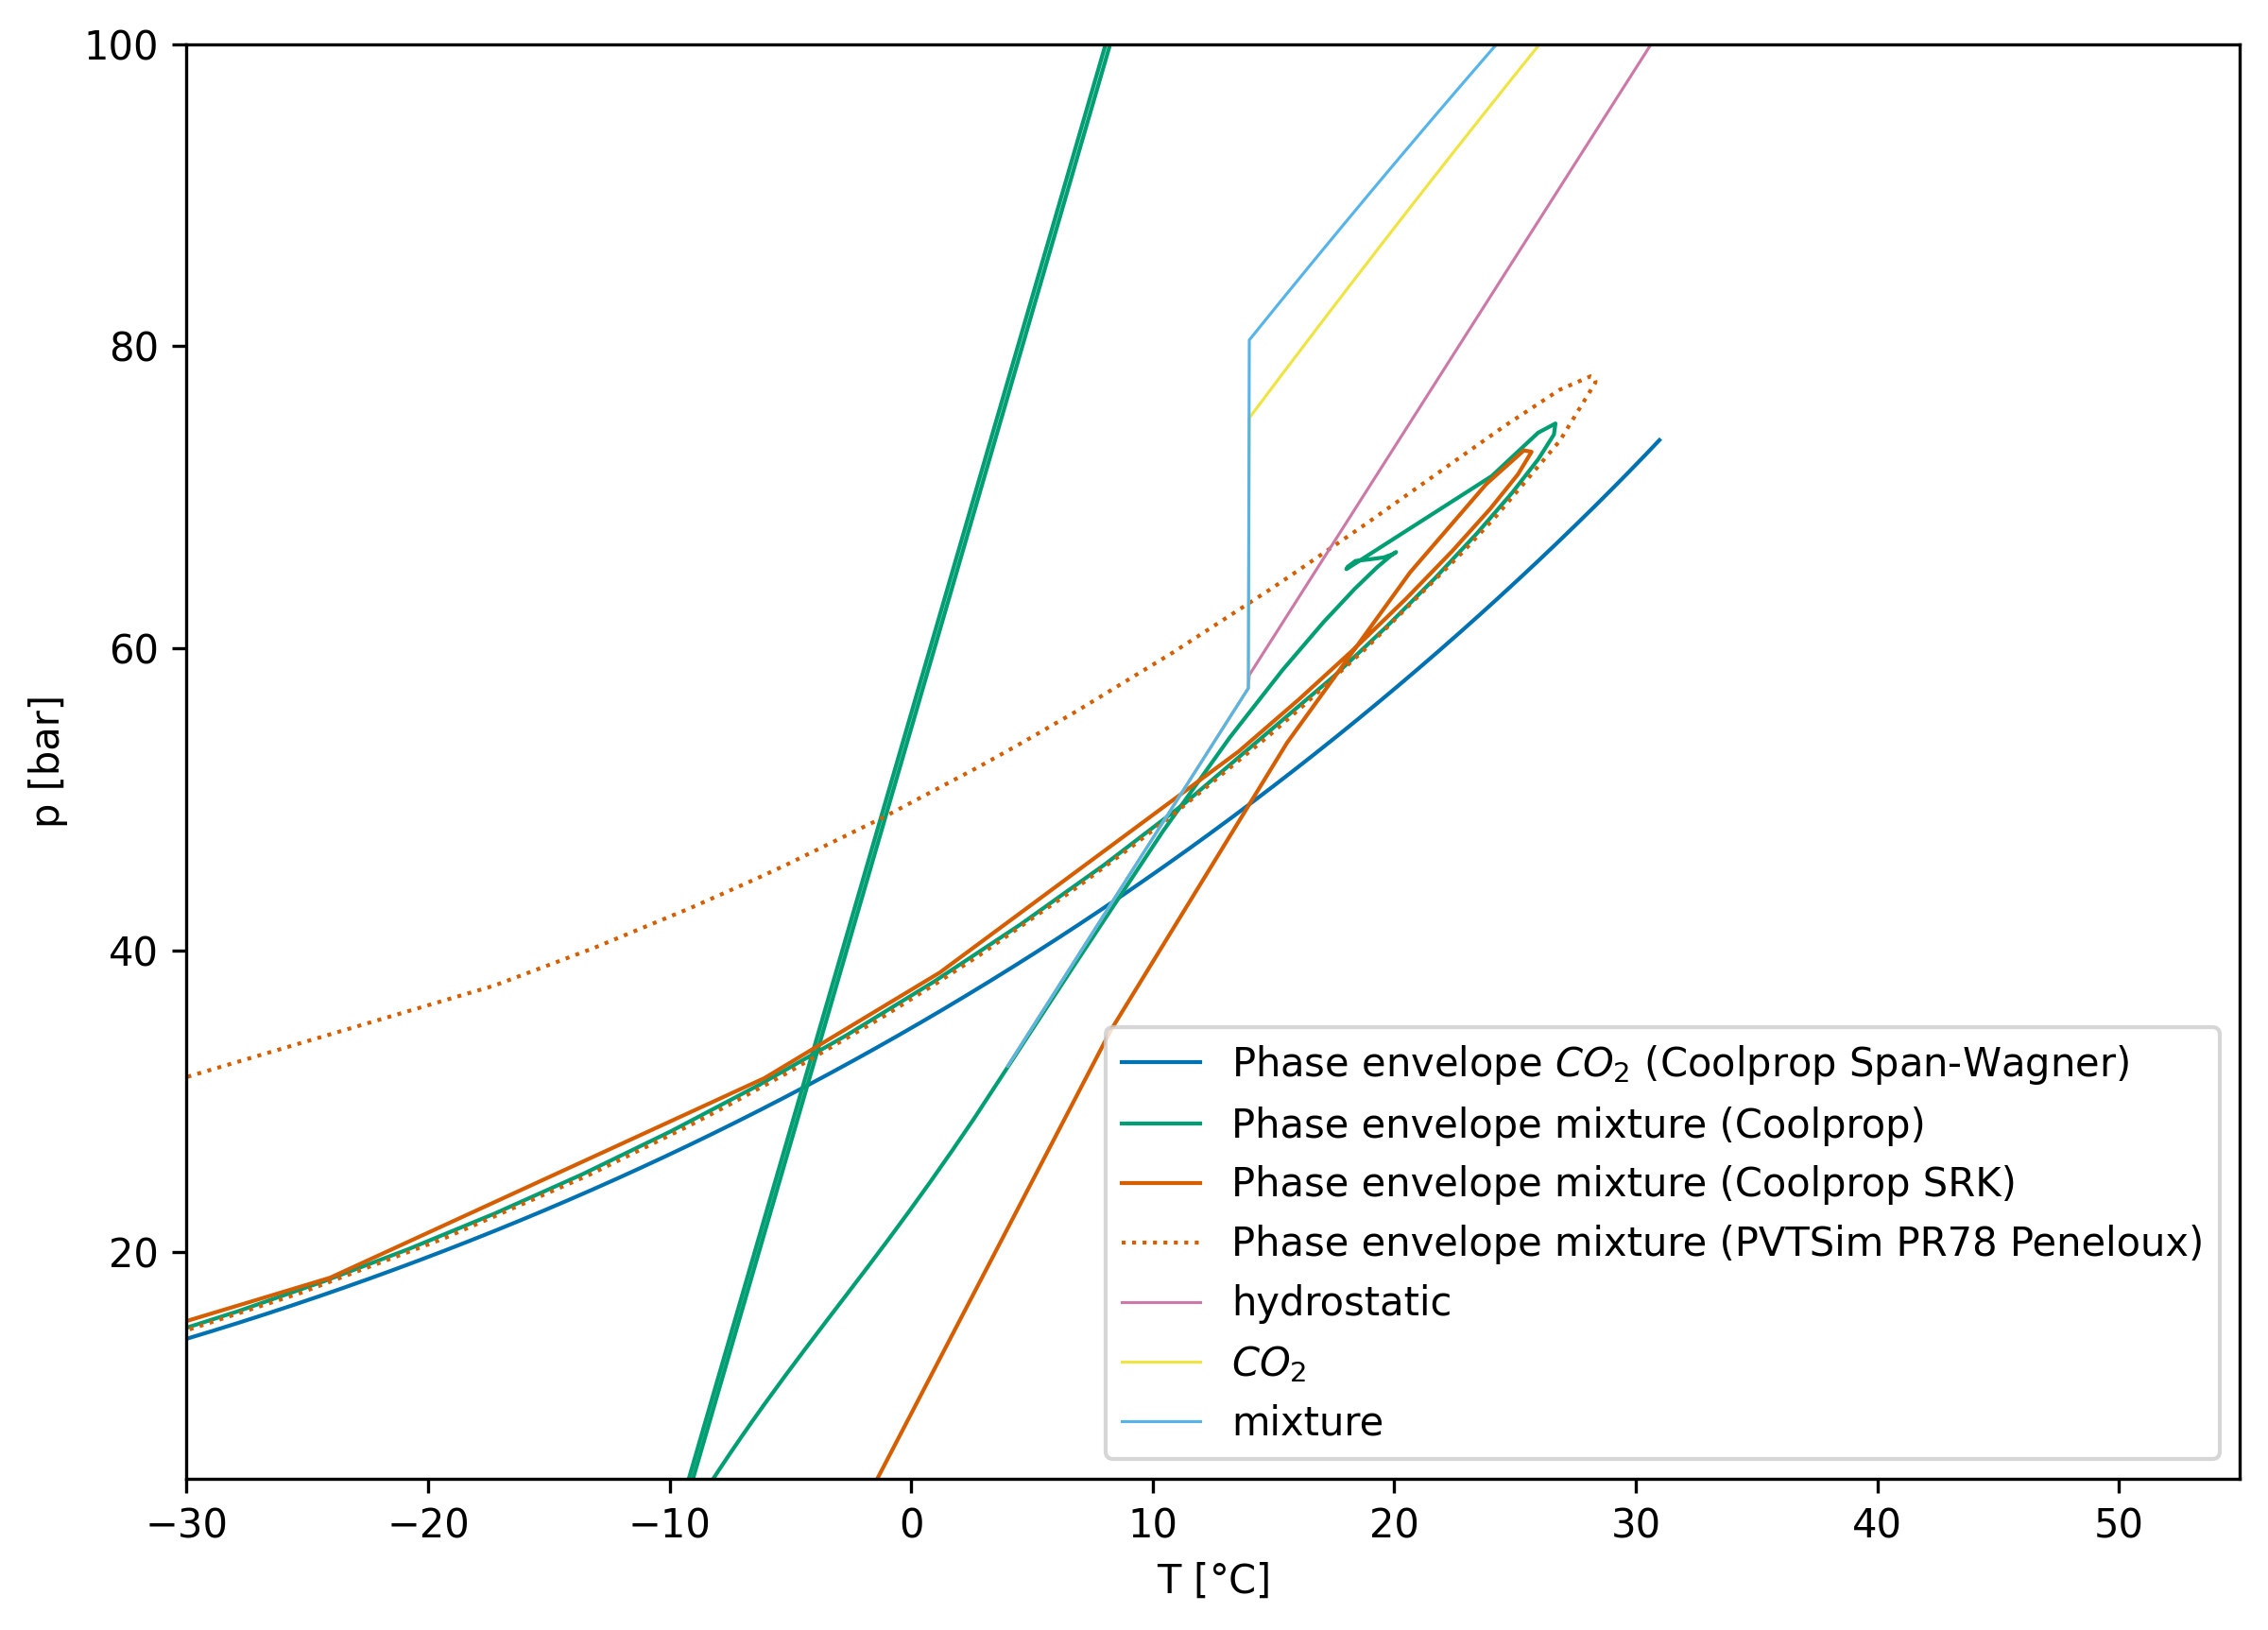

In [39]:
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


HEOS = CP.AbstractState('HEOS', 'CO2&H2&Ar&N2&CH4')
HEOS.set_mole_fractions([0.96, 0.004, 0.01, 0.0084, 0.0178])

HEOS_SRK = CP.AbstractState('HEOS', 'CO2-SRK&H2-SRK&Ar-SRK&N2-SRK&CH4-SRK')
HEOS_SRK.set_mole_fractions([0.96, 0.004, 0.01, 0.0084, 0.0178])



HEOS.build_phase_envelope("dummy")
PE = HEOS.get_phase_envelope_data()


HEOS_SRK.build_phase_envelope("none")
PE_SRK = HEOS_SRK.get_phase_envelope_data()

PE_T = np.array(PE.T)-273.15
PE_p = np.array(PE.p)/1e5

PE_T_SRK = np.array(PE_SRK.T)-273.15
PE_p_SRK = np.array(PE_SRK.p)/1e5

PVTSim_T = [-140.340,-138.719,-137.052,-135.339,-133.576,-131.761,-129.892,-127.965,-125.979,-123.930,-121.815,-119.630,-117.373,-115.038,-112.621,-110.119,-107.526,-104.837,-102.046,-99.148,-96.135,-93.001,-89.739,-86.339,-82.795,-79.095,-75.231,-71.192,-66.966,-62.540,-57.902,-53.039,-47.934,-42.573,-36.941,-31.172,-25.297,-19.354,-13.394,-13.150,-9.150,-7.479,-5.150,-1.150,1.139,2.850,6.850,9.172,10.850,14.850,16.258,18.850,22.850,24.273,26.850,28.329,28.333,28.284,28.128,26.850,24.610,22.850,18.850,15.684,14.850,10.850,6.850,4.729,2.850,-1.150,-5.150,-6.505,-9.150,-13.150,-17.255,-32.715,-48.043,-62.005,-73.024,-75.806,-84.419,-96.327,-108.831,-122.010,-131.639,-139.147,-145.402,-151.192,-155.728,-159.474,-162.046,-162.320,-162.492,-162.610,-162.620,-162.620]

PVTSim_P = [0.010,0.012,0.015,0.019,0.023,0.028,0.035,0.043,0.053,0.065,0.080,0.098,0.121,0.149,0.183,0.225,0.277,0.341,0.419,0.516,0.635,0.782,0.962,1.184,1.457,1.793,2.207,2.716,3.343,4.114,5.063,6.231,7.668,9.437,11.615,14.219,17.304,20.916,25.084,25.267,28.417,29.818,31.858,35.611,37.908,39.699,44.147,46.905,48.985,54.256,56.224,60.018,66.382,68.837,73.718,77.583,77.681,77.916,77.997,77.109,74.753,72.771,68.249,64.771,63.876,59.726,55.828,53.865,52.187,48.802,45.673,44.668,42.788,40.141,37.664,30.318,25.731,23.482,22.812,22.785,23.055,24.343,27.075,32.281,38.726,46.553,56.334,69.991,86.149,106.037,126.076,128.755,130.533,131.816,131.924,131.924]



fig, ax = plt.subplots()
ax.plot(Tphase-273.15, Pphase/1e5, lw=1, label=r'Phase envelope $CO_2$ (Coolprop Span-Wagner)')

ax.plot(PE_T, PE_p, '-', label = 'Phase envelope mixture (Coolprop)', lw=1)
ax.plot(PE_T_SRK, PE_p_SRK, '-', label = 'Phase envelope mixture (Coolprop SRK)', lw=1)

color = ax.get_lines()[-1].get_color()
ax.plot(PVTSim_T, PVTSim_P, ':', label = 'Phase envelope mixture (PVTSim PR78 Peneloux)', color=color, lw=1)


# for x0 in [0.02, 0.2, 0.4, 0.6, 0.8, 0.98]:
#     HEOS.set_mole_fractions([x0, 1 - x0])
#     try:
#         HEOS.build_phase_envelope("dummy")
#         PE = HEOS.get_phase_envelope_data()
#         PELabel = 'Methane, x = ' + str(x0)
#         plt.plot(PE.T, PE.p, '-', label=PELabel)
#     except ValueError as VE:
#         print(VE)

# plt.xlabel('Temperature [K]')
# plt.ylabel('Pressure [Pa]')
# plt.yscale('log')
# plt.title('Phase Envelope for Methane/Ethane Mixtures')
# plt.legend(loc='lower right', shadow=True)
# plt.savefig('methane-ethane.pdf')
# plt.savefig('methane-ethane.png')
# plt.close()

df[312:].plot(x='Temp', y='P_aq', ax=ax, label='hydrostatic')
df[312:].plot(x='Temp', y='P1', ax=ax, label = r'$CO_2$')
df[312:].plot(x='Temp', y='P2', ax=ax, label = 'mixture')




ax.set_xlabel('T [$\degree$C]')
ax.set_ylabel('p [bar]')
ax.set_xlim(-30, 55)
ax.set_ylim(bottom=5, top=100)
ax.legend()

fig.tight_layout()
fig.savefig('phase_envelope.png')


In [ ]:
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt

# Increase the starting pressure a bit, behavior at very low pressure is problematic
CP.set_config_double(CP.PHASE_ENVELOPE_STARTING_PRESSURE_PA, 1e4)

# CP.AbstractState('HEOS', 'CO2&H2&Ar&N2&CH4')
# SRK = CP.AbstractState('SRK','CO2&H2&Ar&N2&CH4')
# # SRK.set_mole_fractions([0.5, 1 - 0.5])
# SRK.set_mole_fractions([0.96, 0.004, 0.01, 0.0084, 0.0178])

# for kij, c in zip([0.0, 0.1],['r','b']):

#     # Set the interaction parameter
#     SRK.set_binary_interaction_double(0, 1, "kij", kij)

#     # Some VLE calculations
#     for p in [1e5, 1e6]:
#         SRK.update(CP.PQ_INPUTS, p, 0)
#         plt.plot(SRK.T(), SRK.p(), '<', color = c)

#         SRK.update(CP.PQ_INPUTS, p, 1)
#         plt.plot(SRK.T(), SRK.p(), '>', color = c)

#     # Phase envelope
#     SRK.build_phase_envelope("")
#     PE = SRK.get_phase_envelope_data()
#     plt.plot(PE.T, PE.p, '-', label = '$k_{ij} = $' + str(kij), color = c)

#     # Critical point
#     pts = SRK.all_critical_points()
#     for pt in pts:
#       plt.plot(pt.T, pt.p, '*', color = c)

# A phase envelope calculated with SRK transformations in a multi-fluid model
# HEOS = CP.AbstractState('HEOS','Methane-SRK&Ethane-SRK')

components = []

components = ['CO2', 'H2', 'Ar', 'N2', 'CH4']
components

components_normal = '&'.join(components)
components_SRK = '&'.join([component+'-SRK' for component in components])
components_PR =  '&'.join([component+'-PengRobinson' for component in components])

HEOS = CP.AbstractState('HEOS', components_normal)
HEOS_SRK = CP.AbstractState('HEOS',components_SRK)
HEOS_PR = CP.AbstractState('HEOS',components_PR)

# HEOS.set_mole_fractions([0.5, 0.5])
HEOS.set_mole_fractions([0.96, 0.004, 0.01, 0.0084, 0.0178])
HEOS_SRK.set_mole_fractions([0.96, 0.004, 0.01, 0.0084, 0.0178])
HEOS_PR.set_mole_fractions([0.96, 0.004, 0.01, 0.0084, 0.0178])

HEOS.build_phase_envelope("none")
HEOS_SRK.build_phase_envelope("none")
HEOS_PR.build_phase_envelope("none")

PE = HEOS.get_phase_envelope_data()
plt.plot(PE.T, PE.p, '-', label = 'multi-fluid')

PE = HEOS_SRK.get_phase_envelope_data()
plt.plot(PE.T, PE.p, '-', label = 'SRK with transformations in multi-fluid')

PE = HEOS_PR.get_phase_envelope_data()
plt.plot(PE.T, PE.p, '-', label = 'PR with transformations in multi-fluid')


plt.xlabel('Temperature [K]')
plt.ylabel('Pressure [Pa]')
plt.yscale('log')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
components_SRK

In [ ]:
HEOS.get_phase_envelope_data()

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [ ]:
HEOS.

In [ ]:
PE.T